In [1]:
import pandas as pd
import numpy as np
from matplotlib.colors import rgb2hex
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import obspy
import matplotlib.patheffects as pe
import matplotlib.ticker as ticker
import calendar
from matplotlib.patches import Rectangle
import cartopy.feature as cfeature
import geopandas
import cmcrameri.cm as cmc
from cartopy.io import img_tiles
import cartopy.crs as ccrs
from math import floor



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def utm_from_lon(lon):
    """
    utm_from_lon - UTM zone for a longitude

    Not right for some polar regions (Norway, Svalbard, Antartica)

    :param float lon: longitude
    :return: UTM zone number
    :rtype: int
    """
    return floor( ( lon + 180 ) / 6) + 1

def scale_bar(ax, proj, length, location=(0.2, 0.05), linewidth=3,
              units='km', m_per_unit=1000):
    """

    http://stackoverflow.com/a/35705477/1072212
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    units is the name of the unit
    m_per_unit is the number of meters in a unit
    """
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    # Projection in metres
    utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * m_per_unit/2, sbcx + length * m_per_unit/2]
    # buffer for scalebar
    buffer = [pe.withStroke(linewidth=5, foreground="w")]
    # Plot the scalebar with buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, path_effects=buffer)
    # buffer for text
    buffer = [pe.withStroke(linewidth=3, foreground="w")]
    # Plot the scalebar label
    t0 = ax.text(sbcx, sbcy, str(length) + ' ' + units, transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
    left = x0+(x1-x0)*0.05
    # Plot the N arrow
    t1 = ax.text(left, sbcy, u'\u25B2\nN', transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
    # Plot the scalebar without buffer, in case covered by text buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, zorder=3)


def cm_plotter(ax,creepmeters_list,gdf,extent,color,shift,region):
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    # Initialize OpenStreetMap tiles
    osm = img_tiles.OSM()

    # Add OpenStreetMap tiles to the plot
      # Zoom level of 8  
    ax.add_image(osm, 10)
        
    # Add natural earth features for oceans and lakes
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                                        edgecolor='face', facecolor='lightblue')
    lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                        edgecolor='face', facecolor='lightblue')
    # Add the land with pale sage green color
    pale_sage_green = '#D0E8D0'  # Very pale sage green color
    land = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                    edgecolor='face', facecolor=pale_sage_green)

    # Add the features to the map
    ax.add_feature(ocean, zorder=0)  # Add oceans first
    ax.add_feature(lakes, zorder=1)  # Add lakes
    ax.add_feature(land, zorder=0)   # Add land with pale sage green

    # Add coastlines and other features if desired
    ax.coastlines(resolution='50m')
    if region == 'CHAF':
        # Load the Natural Earth countries shapefile
        world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

        # Filter for Pakistan
        pakistan = world[world.name == 'Pakistan']

        # Add the outline of Pakistan
        pakistan.boundary.plot(ax=ax, color='red', linewidth=2, transform=ccrs.PlateCarree())


    

    # Add Fault geometries
    ax.add_geometries(gdf.geometry, crs=ccrs.PlateCarree(), edgecolor='black', facecolor="none")
    # Add gridlines with specific label font sizes
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabel_style = {'size': 14}  # 14 pt font size for x-axis gridline labels
    gl.ylabel_style = {'size': 14}

    # Add annotation with an arrow and transform
    for i in range(len(creepmeters_list)):
        face_color = color['creepmeter'][creepmeters_list['Creepmeter_abbrv'].iloc[i]]
        # Default xytext offset
        if shift == 'horizontal':
            # Adjust xytext for specific creepmeter abbreviations
            if creepmeters_list['Creepmeter_abbrv'].iloc[i] in ['XRSW', 'XTA1','XHSW', 'C461/2','CWN1/CWC3','CRR1','XMM1','XSJ2/3',
                                                                'QE30','NS45','SC30','SH30','RR45']:
                if region == 'SOCAL':
                    xytext_lon = creepmeters_list['Longitude'].iloc[i] - 0.2
                else:
                    xytext_lon = creepmeters_list['Longitude'].iloc[i] - 0.1  # Subtract 0.1 for these specific abbreviations
            else:
                if region == 'SOCAL':
                    xytext_lon = creepmeters_list['Longitude'].iloc[i] + 0.2
                else:
                    xytext_lon = creepmeters_list['Longitude'].iloc[i] + 0.1
            xytext_lat = creepmeters_list['Latitude'].iloc[i]
        if shift == 'vertical':
            if region == 'RID':
                xytext_lon = creepmeters_list['Longitude'].iloc[i] 
                xytext_lat = creepmeters_list['Latitude'].iloc[i]-0.1
            elif region == 'EAF':
                if creepmeters_list['Creepmeter_abbrv'].iloc[i] in ['TAS1']:
                    xytext_lon = creepmeters_list['Longitude'].iloc[i]+0.3
                    xytext_lat = creepmeters_list['Latitude'].iloc[i]
                elif creepmeters_list['Creepmeter_abbrv'].iloc[i] in ['YZW1']:
                    xytext_lon = creepmeters_list['Longitude'].iloc[i]
                    xytext_lat = creepmeters_list['Latitude'].iloc[i]-0.3
                elif creepmeters_list['Creepmeter_abbrv'].iloc[i] in ['YZE1']:
                    xytext_lon = creepmeters_list['Longitude'].iloc[i]+0.2
                    xytext_lat = creepmeters_list['Latitude'].iloc[i]-0.2
                elif creepmeters_list['Creepmeter_abbrv'].iloc[i] in ['BAL1']:
                    xytext_lon = creepmeters_list['Longitude'].iloc[i]
                    xytext_lat = creepmeters_list['Latitude'].iloc[i]-0.2
                else:
                    xytext_lon = creepmeters_list['Longitude'].iloc[i] 
                    xytext_lat = creepmeters_list['Latitude'].iloc[i] + 0.2
            elif region =='NAF':
                xytext_lon = creepmeters_list['Longitude'].iloc[i] 
                xytext_lat = creepmeters_list['Latitude'].iloc[i]+0.1
                if creepmeters_list['Creepmeter_abbrv'].iloc[i] in ['TEP1']:
                    xytext_lon = creepmeters_list['Longitude'].iloc[i]
                    xytext_lat = creepmeters_list['Latitude'].iloc[i]-0.1
                if creepmeters_list['Creepmeter_abbrv'].iloc[i] in ['CER1']:
                    xytext_lon = creepmeters_list['Longitude'].iloc[i]+0.1
                    xytext_lat = creepmeters_list['Latitude'].iloc[i] - 0.15
                if creepmeters_list['Creepmeter_abbrv'].iloc[i] in ['HAM1']:
                    xytext_lon = creepmeters_list['Longitude'].iloc[i]+0.15
                    xytext_lat = creepmeters_list['Latitude'].iloc[i]+0.1
                if creepmeters_list['Creepmeter_abbrv'].iloc[i] in ['CHE1']:
                    xytext_lon = creepmeters_list['Longitude'].iloc[i]-0.05
                    xytext_lat = creepmeters_list['Latitude'].iloc[i]+0.1
                if creepmeters_list['Creepmeter_abbrv'].iloc[i] in ['PET1']:
                    xytext_lon = creepmeters_list['Longitude'].iloc[i]-0.45
                    xytext_lat = creepmeters_list['Latitude'].iloc[i]+0.2
                if creepmeters_list['Creepmeter_abbrv'].iloc[i] in ['WSZ1']:
                    xytext_lon = creepmeters_list['Longitude'].iloc[i]-0.2
                    xytext_lat = creepmeters_list['Latitude'].iloc[i]-0.1
                if creepmeters_list['Creepmeter_abbrv'].iloc[i] in ['ISW1']:
                    xytext_lon = creepmeters_list['Longitude'].iloc[i]
                    xytext_lat = creepmeters_list['Latitude'].iloc[i]-0.1
                if creepmeters_list['Creepmeter_abbrv'].iloc[i] in ['ESZ1']:
                    xytext_lon = creepmeters_list['Longitude'].iloc[i]-0.35
                    xytext_lat = creepmeters_list['Latitude'].iloc[i]+0.1
                if creepmeters_list['Creepmeter_abbrv'].iloc[i] in ['INW1']:
                    xytext_lon = creepmeters_list['Longitude'].iloc[i]-0.25
                    xytext_lat = creepmeters_list['Latitude'].iloc[i]+0.2
            else:
                xytext_lon = creepmeters_list['Longitude'].iloc[i] 
                xytext_lat = creepmeters_list['Latitude'].iloc[i] - 1

        
        
        
        ax.annotate(
            creepmeters_list['Creepmeter_abbrv'].iloc[i], 
            xy=(creepmeters_list['Longitude'].iloc[i], creepmeters_list['Latitude'].iloc[i]),
            xytext=(xytext_lon, xytext_lat), 
            arrowprops=dict(facecolor=face_color, edgecolor = face_color, arrowstyle='->', lw=1.5),
            bbox=dict(boxstyle='round,pad=0.3', edgecolor=face_color, facecolor='lightgrey'),
            fontsize=8, ha='center', va='center',
            transform=ccrs.PlateCarree()  # Make sure coordinates are correct
        )
        # Scatter points for creepmeters
        ax.scatter(
            creepmeters_list['Longitude'].iloc[i], 
            creepmeters_list['Latitude'].iloc[i], 
            color=face_color, 
            edgecolor='black', 
            s=100, 
            zorder=100, 
            transform=ccrs.Geodetic()
        )
        scale_bar(ax, ccrs.PlateCarree(), 10)
    return





def ymd_to_ydec(ST):
    y = int(ST.strftime("%Y"))
    dt_starter = dt.datetime(y,1,1,0,0,0)
    diff = (ST.replace(tzinfo=None)-dt_starter)/dt.timedelta(days=1)
    isleapyear = calendar.isleap(y)
    if isleapyear == True:
        diff_dec = diff/366
    else:
        diff_dec = diff/365
    date_dec = y+diff_dec
    return date_dec

def timeseries_plot(ax,file_codes,instrument_database,sample_freqs,creepmeter_list,color_dict):
    for i in range(len(file_codes)):
        try:
            path = "../../Data/DATA_tidied/SAC/{q}.SAC".format(q =file_codes[i])
            print(path)
            st = obspy.read(path)
            tr = st[0]
            #tr.interpolate(sampling_rate=tr.stats.sampling_rate)
            tm = tr.times("utcdatetime")
            creep = tr.data
            sample_rate =  round(tr.stats.delta)/60
            tm_dt = []
            for w in range(len(tm)):
                tm_new = tm[w].datetime
                tm_dt.append(tm_new)
            file_loc = np.where(instrument_database["File_code"]==file_codes[i])



            linestyles = ['-', '--', ':', '-.', '---', '-', '-', '-', '~', '-']
            bool_line = np.where(np.array(sample_freqs) == instrument_database['Sampling rate, mins'].loc[file_loc[0][0]])[0][0]
            line_style = linestyles[bool_line]

            
            if instrument_database["Sampling rate, mins"].loc[file_loc[0][0]] ==10:
                foreground='grey'
            else:
                foreground = 'black'
            ax.plot(tm_dt,creep,color=color_dict['creepmeter'][instrument_database['Creepmeter_abbrv'].loc[file_loc[0][0]]],
                        linewidth=2)#,path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])

        except FileNotFoundError:
            dummy=10


    for k in range(len(creepmeter_list)):
        ax.plot([],[],color=color_dict['creepmeter'][creepmeter_list[k]],linewidth=1,label = creepmeter_list[k])#,
                #path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
            
    ax.set_ylabel("Displacement, mm",fontsize=14)
    plt.xticks(fontsize=12,rotation=45)
    plt.yticks(fontsize=12)
    ax.legend(ncol=2)
    return

def creepmeter_timespans(ax,creepmeter_list,instrument_database,sample_freqs,color_dict,region_CMs):
    for i in range(len(creepmeter_list)):
        boolarr = np.where(instrument_database['Creepmeter_abbrv']==creepmeter_list[i])[0]
        selected = instrument_database.iloc[boolarr]
        selected['Sampling rate, mins'] = selected['Sampling rate, mins'].astype(str).str.strip()

        hatchings = ['-', '||', '//', '\\', '+', '*', 'x', 'o', 'O', '.', '-.']
        for j in range(len(selected)):
            
            duration = selected['diff'].iloc[j].days/365
            fcolour = color_dict['creepmeter'][selected['Creepmeter_abbrv'].iloc[j]]
            bool_hatch = np.where(np.array(sample_freqs) == selected['Sampling rate, mins'].iloc[j])[0][0]
            hatch_style = hatchings[bool_hatch]
            y = ymd_to_ydec(pd.to_datetime(selected['Start Time'].iloc[j]))
            plt.broken_barh([(y,duration)],(i,0.5),facecolors=fcolour,\
                            edgecolors='black',hatch=hatch_style,zorder=i+1)
    
    sampling_freq_all = np.unique(region_CMs['Sampling rate, mins'])
    df = pd.DataFrame({'Sampling rate, mins':sampling_freq_all})

    # Extract numeric part and unit part
    df['Numeric'] = df['Sampling rate, mins'].str.extract(r'(\d+)').astype(int)
    df['Unit'] = df['Sampling rate, mins'].str.extract(r'([A-Z]+)')

    # Map units to words
    unit_mapping = {'T': 'mins', 'S': 'secs'}
    df['Unit in words'] = df['Unit'].map(unit_mapping)

    # Combine numeric part and unit in words
    df['Readable format'] = df['Numeric'].astype(str) + ' ' + df['Unit in words']

    # Drop intermediate columns if needed
    df = df.drop(columns=['Numeric', 'Unit'])

    sampling_freq_all_words= np.array(df['Readable format'])

    for k in range(len(sampling_freq_all)):
        bool_hatch = np.where(np.array(sample_freqs)==sampling_freq_all[k])[0][0]
        hatch_style = hatchings[bool_hatch]
        ax.add_patch(Rectangle((2024,0.25),0,0, fc ='white',  ec ='black',zorder=-1,hatch=hatch_style,\
                                label='{k} min'.format(k=sampling_freq_all_words[k])) )
    tick_locations = list(np.linspace(0.25,i+.25,i+1))
    plt.ylim([i+0.5,0])

    plt.yticks(tick_locations,list(creepmeter_list),fontsize=12)

    plt.xticks(fontsize=12,rotation=45)
    
    plt.ylabel('Creepmeter',fontsize=14)
    left,right = ax.get_xlim()
    plt.xlim(left,right)
    for axis in [ax.xaxis]:
        axis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.legend(title='Sampling rate')

    return

from matplotlib.colors import rgb2hex

def generate_color_dict(region, slicedCM):

    region_data = {
        'HOL': {
            'extent': [-121.75,-121.0,36.5,37.0],
            'creepmeter': {
                'XSH1': 0, 'SJN1': 1, 'XSJ2/3': 2, 'XSJ2': 2, 'XSJ3': 2,
                'XHR1/2/3': 3, 'XHR1': 3, 'XHR2': 3, 'XHR3': 3,
                'CWN1/CWC3': 4, 'CWC3': 4, 'CWN1': 5,
                'FCR1': 6, 'XMR1': 7,
            }
        },
        'HAY': {
            'extent': [-122.4,-121.8,37.5,38],
            'creepmeter': {
                'CPP1': 0, 'CTM1': 1, 'COZ1': 2, 'CHP1': 3, 'CFW1': 4,
            }
        },
        'PARK': {
            'extent': [-120.75,-120.1,35.65,36.1],
            'creepmeter': {
                'XSC1': 0, 'XMM1': 1, 'XMD1': 2, 'XVA1': 3, 'XRSW': 4,
                'XPK1/2': 5, 'XPK1': 5, 'XPK2': 5,
                'XTA1': 6, 'XHSW': 7, 'WKR1': 8, 'CRR1': 9, 'XGH1': 10,
                'C461': 11, 'C462': 11, 'C461/2': 11, 'X461': 12,
            }
        },
        'SOCAL': {
            'extent': [-116.4,-115.2,32.5,33.75],
            'creepmeter': {
                'DU30': 6, 'FE30': 4, 'IR30': 2, 'NS45': 3, 'QE30': 1,
                'QW30': 0, 'RR45': 9, 'SC30': 5, 'SC72': 5, 'SCTE': 5,
                'SC30/72/TE': 5, 'SH30/90': 2, 'SH30': 7, 'SH90': 7,
                'SU30I': 8, 'SU30C': 8, 'SU30C/I': 8,
            }
        },
        'EAF': {
            'extent': [36.0, 40.25, 36.0, 39],
            'creepmeter': {
                'BAL1': 2, 'GOK1': 3, 'GOZ1': 6, 'HAS1': 1, 'HAT1': 10,
                'KAR1': 4, 'KIR1': 0, 'ORM1': 9, 'PAN1/PAS1': 12,
                'PAN1': 12, 'PAS1': 13, 'SIV1': 11, 'TAS1': 8,
                'YZE1': 7, 'YZW1': 5,
            }
        },
        'NAF': {
            'extent': [29.5, 33.1,40.5, 41.2],
            'creepmeter': {
                'SEL1': 0, 'TEP1': 1, 'PET1': 0, 'WSZ1': 1, 'ESZ1': 2,
                'ISW1': 3, 'INW1': 4, 'CHE1': 5, 'HAM1': 6, 'CER1': 7,
            }
        },
        'RID': {
            'extent': [-118,-117, 35,36],
            'creepmeter': {
                'GD': 0, 'GT': 1, 'RA/RB': 2, 'RA': 2, 'RB': 3, 'GS': 4,
                'R7': 5, 'GB': 6,
            }
        },
        'UTA': {
            'extent': [-114.2,-108.5, 36.8,42.2],
            'creepmeter': {
                'CAN1': 0,
            }
        },
        'CHAF': {
            'extent': [61, 78, 23, 38],
            'creepmeter': {
                'CHA1': 0,
            }
        },
    }

    # Default case if region is not found
    if region not in region_data:
        return None, {}

    region_info = region_data[region]
    extent = region_info['extent']

    # Generate color_dict using slicedCM and the creepmeters
    color_dict = {
        'creepmeter': {
            key: rgb2hex(slicedCM[index]) for key, index in region_info['creepmeter'].items()
        }
    }

    return extent, color_dict


def six_panel_plot(creep_catalogue,instrument_database,region,save_name,creepmeter_region,cmap,gdf,shift,creepmeter_list):

    region_CMs = instrument_database[instrument_database["Network"]==region]
    file_codes = list(region_CMs["File_code"])
    order = creepmeter_list
    events_region = creep_catalogue[creep_catalogue["Network"]==region]
    
    events_region.sort_values(by="Latitude",inplace=True,ascending=False)
    events_region['Creepmeter_abbrv'] = events_region['Creepmeter_abbrv'].astype(str)
    events_region['Sampling rate'] = events_region['Sampling rate, mins'].astype(str)+' min'
    
    try:
        slicedCM = cmap(np.linspace(0, 1, len(creepmeter_list)))
    except:
        slicedCM = cmap(np.linspace(0, 1, 2))

    extent,color_dict = generate_color_dict(region,slicedCM)

    fig = plt.figure(figsize=(17, 14))

    ax1= plt.subplot(3, 2, 1, projection=ccrs.PlateCarree())
    cm_plotter(ax1,creepmeter_region,gdf,extent,color_dict,shift,region)
    

    ax2=plt.subplot(3,2,2)
    sample_freqs = ['10S','30S','1T', '2T', '5T','10T' ,'15T' , '30T', '60T']
    creepmeter_list.reset_index(inplace=True,drop=True)
    creepmeter_timespans(ax2,creepmeter_list,instrument_database,sample_freqs,color_dict,region_CMs)


    

    ax3=plt.subplot(3,2,3)
    timeseries_plot(ax3,file_codes,instrument_database,sample_freqs,creepmeter_list,color_dict)



    sliced_palette = cmap(np.linspace(0, 1, 9))
    palette_new = {'10 secs': rgb2hex(sliced_palette[0]), '30 secs':rgb2hex(sliced_palette[1]),'1 mins':rgb2hex(sliced_palette[2]),
                      '2 mins':rgb2hex(sliced_palette[3]),'5 mins':rgb2hex(sliced_palette[4]),'10 mins':rgb2hex(sliced_palette[5]),
                      '15 mins': rgb2hex(sliced_palette[6]),'30 mins':rgb2hex(sliced_palette[7]), '60 mins': rgb2hex(sliced_palette[8])}

    ax4 = plt.subplot(3,2,4)
    def no_events(ax,events_region,palette_new,order):
        sns.countplot(events_region, x="Creepmeter_abbrv",hue='Readable format',palette=palette_new,order=order)
        ax.set_xlabel('Creepmeters',fontsize=14)
        ax.set_ylabel('Number of events',fontsize=14)
        plt.xticks(fontsize=12,rotation=45)
        plt.yticks(fontsize=12)
        return
    no_events(ax4,events_region,palette_new,order)

    ax5 = plt.subplot(3,2,5)
    def displacement(ax,events_region,palette_new,order):
        sns.boxplot(data=events_region, x="Displacement, mm", y="Creepmeter_abbrv",hue="Readable format",palette=palette_new,\
                    order=order,flierprops={"marker": "o"})
        ax.set_ylabel('Creepmeters',fontsize=14)
        ax.set_xlabel('Displacement, mm',fontsize=14)
        ax.set_xscale('log')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        return
    displacement(ax5,events_region,palette_new,order)

    ax6 = plt.subplot(3,2,6)
    def duration(ax,events_region,palette_new,order):
        sns.boxplot(data=events_region, x="Duration, hrs", y="Creepmeter_abbrv",hue="Readable format",palette=palette_new,\
                    order=order,flierprops={"marker": "o"})
        ax.set_xscale('log')
        ax.set_ylabel('Creepmeters',fontsize=14)
        ax.set_xlabel('Duration, hrs',fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        return
    duration(ax6,events_region,palette_new,order)
    
    fig.tight_layout()
    fig.text(0.02,0.97,'a)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 14,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.text(0.5,0.97,'b)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 14,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.text(0.02,0.65,'c)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 14,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.text(0.5,0.65,'d)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 14,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.text(0.02,0.33,'e)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 14,\
              bbox=dict(facecolor='white', boxstyle='round'))
    fig.text(0.5,0.33,'f)',verticalalignment='center',horizontalalignment='center', color='black', fontsize = 14,\
              bbox=dict(facecolor='white', boxstyle='round'))
    #fig.savefig("../../Creep_catalog_stats_figures/{k}_summary_plot_lifespan_and_map.pdf".format(k=save_name))
    #fig.savefig("../../Creep_catalog_stats_figures/{k}_summary_plot_lifespan_and_map.png".format(k=save_name))
    plt.show()


    return

In [3]:
creepmeters = pd.read_excel('../../Data/Creepmeter_list.xlsx')
creepmeters.drop(creepmeters[creepmeters['Regular sampling mins']!="Yes"].index,inplace=True)
creepmeters.reset_index(inplace=True,drop=True)

########## East Anatolia ############
EAF = creepmeters.drop(creepmeters[creepmeters["Network"]!="EAF"].index)
EAF.reset_index(inplace=True,drop=True)
EAF_list = EAF['Creepmeter_abbrv']
EAF['Creepmeter_abbrv'].iloc[8]='PAN1/PAS1'
EAF.drop([9],inplace=True)
EAF.sort_values(by='Latitude', ascending=False,inplace=True)
EAF.reset_index(inplace=True,drop=True)


########## North Anatolia ############
NAF = creepmeters.drop(creepmeters[creepmeters["Network"]!="NAF"].index)
NAF_list = NAF['Creepmeter_abbrv']
NAF.sort_values(by='Longitude',inplace=True)
NAF.reset_index(inplace=True,drop=True)


########## Parkfield ############
PARK = creepmeters.drop(creepmeters[creepmeters["Network"]!="PARK"].index)
PARK.sort_values(by='Latitude', ascending=False,inplace=True)
PARK.reset_index(inplace=True,drop=True)
PARK.drop([1,8],inplace=True)
PARK_list = PARK['Creepmeter_abbrv']
PARK_list.reset_index(inplace=True,drop=True)
PARK.reset_index(inplace=True,drop=True)
PARK['Creepmeter_abbrv'].iloc[13] = 'C461/2'
PARK['Creepmeter_abbrv'].iloc[5] = 'XPK1/2'
PARK.drop([6,12],inplace=True)
PARK.reset_index(inplace=True,drop=True)


########## Hayward ############
HAY = creepmeters.drop(creepmeters[creepmeters["Network"]!="HAY"].index)
HAY_list = HAY['Creepmeter_abbrv']
HAY.sort_values(by='Latitude', ascending=False,inplace=True)
HAY.reset_index(inplace=True,drop=True)
HAY_list = HAY['Creepmeter_abbrv']

########## Hollister ############
HOL = creepmeters.drop(creepmeters[creepmeters["Network"]!="HOL"].index)
HOL.reset_index(inplace=True,drop=True)
HOL_1 = HOL.copy(deep=True)


HOL['Creepmeter_abbrv'].iloc[0] = 'CWN1/CWC3'
HOL['Creepmeter_abbrv'].iloc[4] = 'XHR1/2/3'
HOL['Creepmeter_abbrv'].iloc[8] = 'XSJ2/3'
HOL.drop([1,5,6,9],inplace=True)
HOL.reset_index(inplace=True,drop=True)

CAL = creepmeters.drop(creepmeters[creepmeters["Network"]!="CAL"].index)
CAL.reset_index(inplace=True,drop=True)

HOL_all = pd.concat([HOL_1,CAL])
HOL_all.sort_values(by='Latitude', ascending=False,inplace=True)
HOL_all.reset_index(inplace=True,drop=True)


HOL = pd.concat([HOL,CAL],ignore_index=True)
HOL.sort_values(by='Latitude', ascending=False,inplace=True)
HOL.reset_index(inplace=True,drop=True)

HOL_list = HOL_all['Creepmeter_abbrv']

########## Chaman ############
CHAF = creepmeters.drop(creepmeters[creepmeters["Network"]!="CHAF"].index)
CHAF.reset_index(inplace=True,drop=True)
CHAF_list = CHAF['Creepmeter_abbrv']

########## Utah ############
UTA = creepmeters.drop(creepmeters[creepmeters["Network"]!="UTA"].index)
UTA.reset_index(inplace=True,drop=True)
UTA_list = UTA['Creepmeter_abbrv']


########## SoCal ############
SOCAL= creepmeters.drop(creepmeters[creepmeters["Network"]!="SOCAL"].index)
SOCAL.reset_index(inplace=True,drop=True)
SOCAL.drop([8,9,11,13],inplace=True)
SOCAL.sort_values(by='Latitude', ascending=False,inplace=True)
SOCAL.reset_index(inplace=True,drop=True)
SOCAL_list = SOCAL['Creepmeter_abbrv']

########## Ridgecrest ############
RID = creepmeters.drop(creepmeters[creepmeters["Network"]!="RID"].index)
RID.reset_index(inplace=True,drop=True)
RID.sort_values(by='Longitude',inplace=True)
RID.reset_index(inplace=True,drop=True)
RID_list = RID['Creepmeter_abbrv']
RID['Creepmeter_abbrv'].iloc[2] = 'RA/RB'
RID.drop([3],inplace=True)
RID.reset_index(inplace=True,drop=True)


########## Import Faults ############
gdf_Asia = geopandas.read_file("../../Data/GIS_Files/AFEAD_v2022/AFEAD_v2022.shp")
gdf_USA = geopandas.read_file("../../Data/GIS_Files/Shapefile/QFaults.shp")

gdf_Cali = gdf_USA.drop(gdf_USA[gdf_USA.Location!='California'].index)
gdf_Utah = gdf_USA.drop(gdf_USA[gdf_USA.Location!='Utah'].index)


/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1653188681.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EAF['Creepmeter_abbrv'].iloc[8]='PAN1/PAS1'
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1653188681.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PARK['Creepmeter_abbrv'].iloc[13] = 'C461/2'
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1653188681.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

In [4]:
Creepmeter_dataframe = pd.read_csv('../../Data/DATA_tidied/creepmeter_metadata_post_standardisation_sac_codes.csv',index_col=0)
Creepmeter_dataframe['diff'] = pd.to_datetime(Creepmeter_dataframe['End Time']) - pd.to_datetime(Creepmeter_dataframe['Start Time'])
# Extract numeric part and unit part
Creepmeter_dataframe['Numeric'] = Creepmeter_dataframe['Sampling rate, mins'].str.extract(r'(\d+)').astype(int)
Creepmeter_dataframe['Unit'] = Creepmeter_dataframe['Sampling rate, mins'].str.extract(r'([A-Z]+)')

# Map units to words
unit_mapping = {'T': 'mins', 'S': 'secs'}
Creepmeter_dataframe['Unit in words'] = Creepmeter_dataframe['Unit'].map(unit_mapping)

# Combine numeric part and unit in words
Creepmeter_dataframe['Readable format'] = Creepmeter_dataframe['Numeric'].astype(str) + ' ' + Creepmeter_dataframe['Unit in words']

# Drop intermediate columns if needed
Creepmeter_dataframe = Creepmeter_dataframe.drop(columns=['Numeric', 'Unit'])
Creepmeter_dataframe.drop([25,26],inplace=True)
Creepmeter_dataframe.reset_index(inplace=True,drop=True)

In [5]:
df_all = pd.read_csv("../../Data/DATA_tidied/Picks/Test_of_all_picks.csv",index_col=0)
# Extract numeric part and unit part
df_all['Numeric'] = df_all['Sampling rate, mins'].str.extract(r'(\d+)').astype(int)
df_all['Unit'] = df_all['Sampling rate, mins'].str.extract(r'([A-Z]+)')

# Map units to words
unit_mapping = {'T': 'mins', 'S': 'secs'}
df_all['Unit in words'] = df_all['Unit'].map(unit_mapping)

# Combine numeric part and unit in words
df_all['Readable format'] = df_all['Numeric'].astype(str) + ' ' + df_all['Unit in words']

# Drop intermediate columns if needed
df_all = df_all.drop(columns=['Numeric', 'Unit'])

/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1698570974.py:417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region.sort_values(by="Latitude",inplace=True,ascending=False)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1698570974.py:418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region['Creepmeter_abbrv'] = events_region['Creepmeter_abbrv'].astype(str)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1698570974.py:419: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

../../Data/DATA_tidied/SAC/XMR1_10T.SAC
../../Data/DATA_tidied/SAC/XHR1_10T.SAC
../../Data/DATA_tidied/SAC/XSJ2_10T.SAC
../../Data/DATA_tidied/SAC/CWC3_10T.SAC
../../Data/DATA_tidied/SAC/CWN1_10T.SAC
../../Data/DATA_tidied/SAC/XHR2_10T.SAC
../../Data/DATA_tidied/SAC/SJN1_10T.SAC
../../Data/DATA_tidied/SAC/XSJ3_10T.SAC
../../Data/DATA_tidied/SAC/XHR3_10T.SAC
../../Data/DATA_tidied/SAC/SJN1_30T.SAC
../../Data/DATA_tidied/SAC/XMR1_1T.SAC
../../Data/DATA_tidied/SAC/CWN1_2T.SAC
../../Data/DATA_tidied/SAC/CWN1_1T.SAC
../../Data/DATA_tidied/SAC/SJN1_1T.SAC
../../Data/DATA_tidied/SAC/FCR1_1T.SAC
../../Data/DATA_tidied/SAC/XHR3_1T.SAC


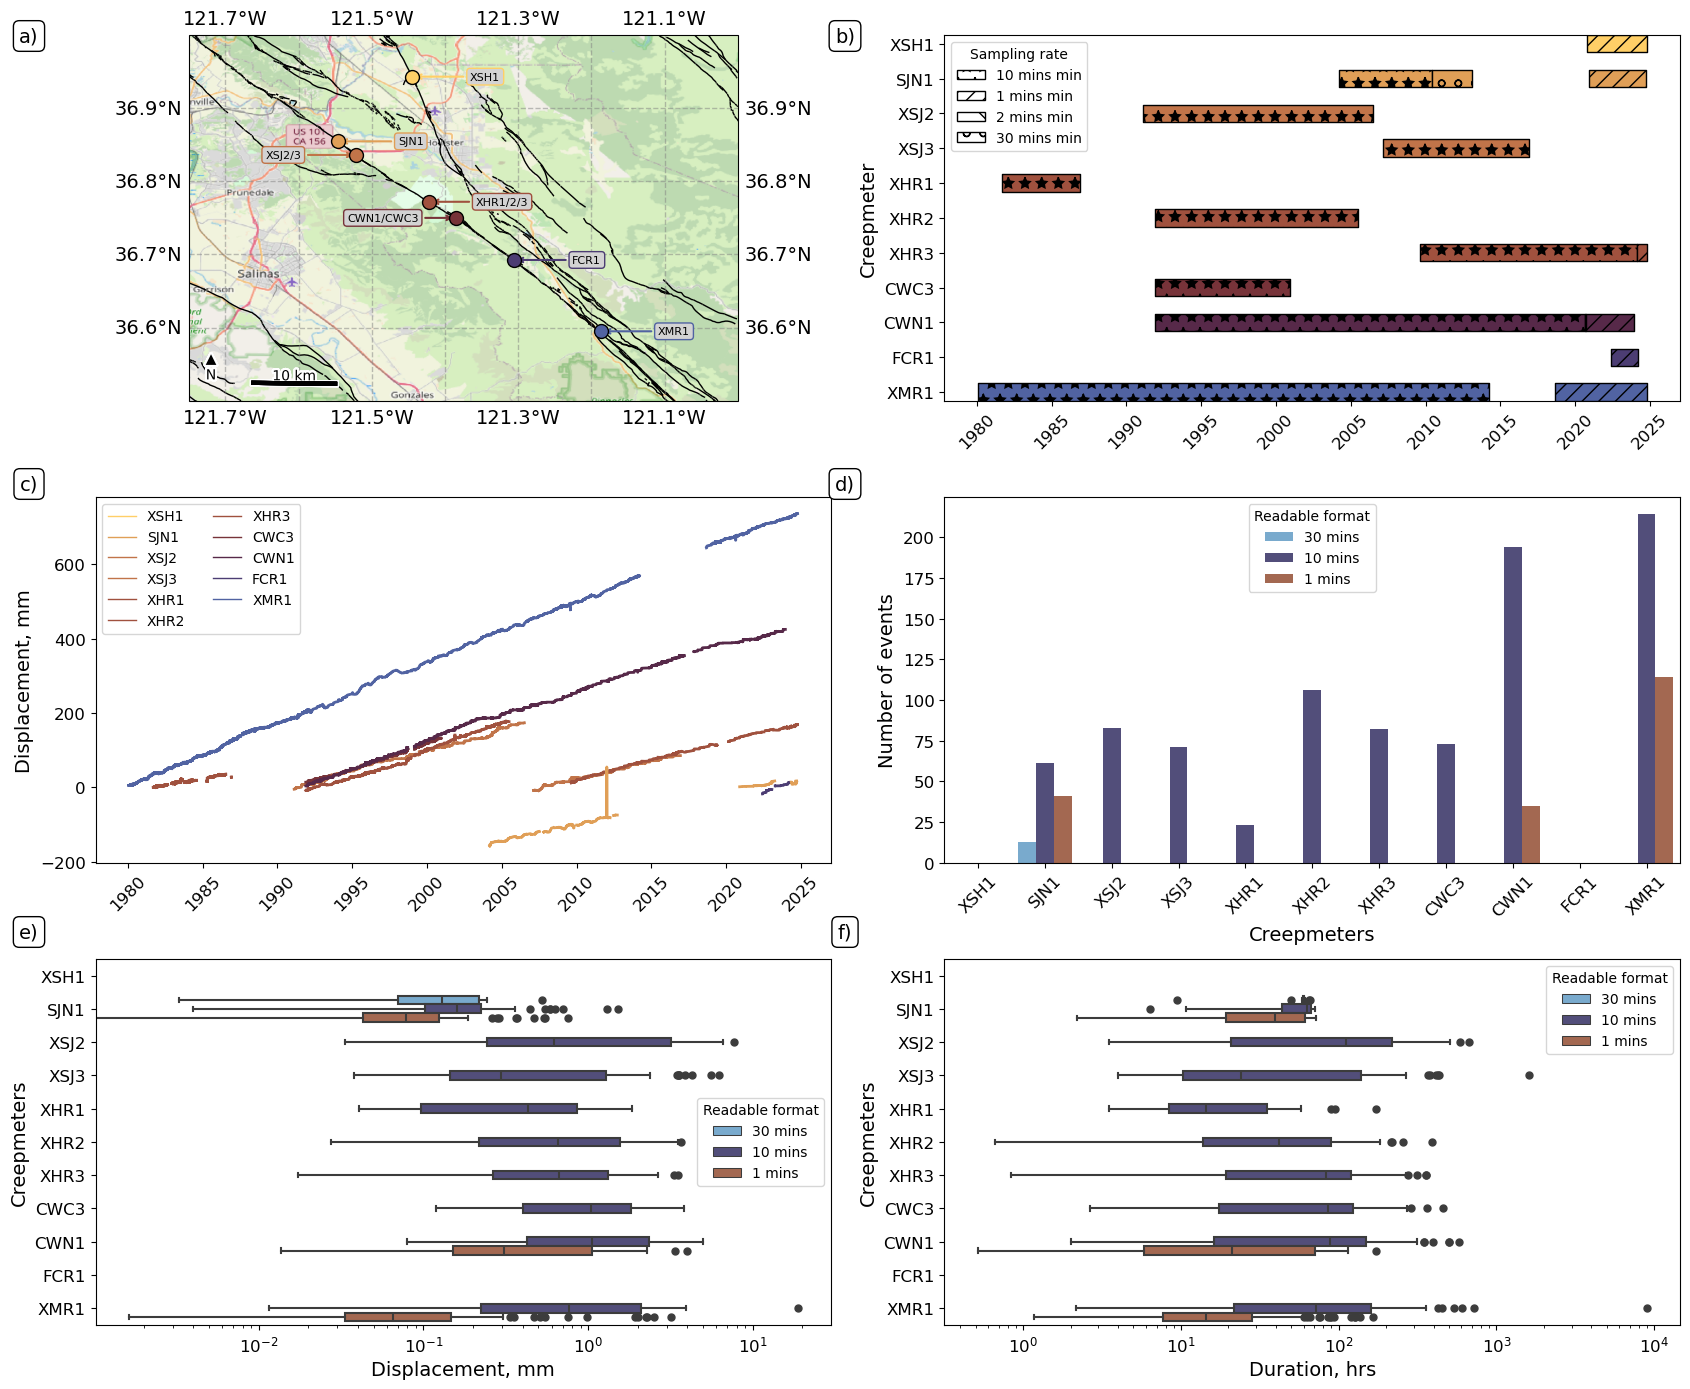

In [6]:
six_panel_plot(df_all,Creepmeter_dataframe,'HOL','Hollister',HOL,cmc.managua,gdf_Cali,'horizontal',HOL_list)

/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1698570974.py:417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region.sort_values(by="Latitude",inplace=True,ascending=False)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1698570974.py:418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region['Creepmeter_abbrv'] = events_region['Creepmeter_abbrv'].astype(str)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1698570974.py:419: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

../../Data/DATA_tidied/SAC/CFW1_60T.SAC
../../Data/DATA_tidied/SAC/CHP1_10T.SAC
../../Data/DATA_tidied/SAC/CPP1_10T.SAC
../../Data/DATA_tidied/SAC/COZ1_60T.SAC
../../Data/DATA_tidied/SAC/CTM1_60T.SAC
../../Data/DATA_tidied/SAC/CFW1_10T.SAC
../../Data/DATA_tidied/SAC/CTM1_10T.SAC
../../Data/DATA_tidied/SAC/COZ1_10T.SAC
../../Data/DATA_tidied/SAC/CTM1_1T.SAC
../../Data/DATA_tidied/SAC/COZ1_1T.SAC
../../Data/DATA_tidied/SAC/CFW1_1T.SAC
../../Data/DATA_tidied/SAC/CHP1_1T.SAC
../../Data/DATA_tidied/SAC/CPP1_1T.SAC


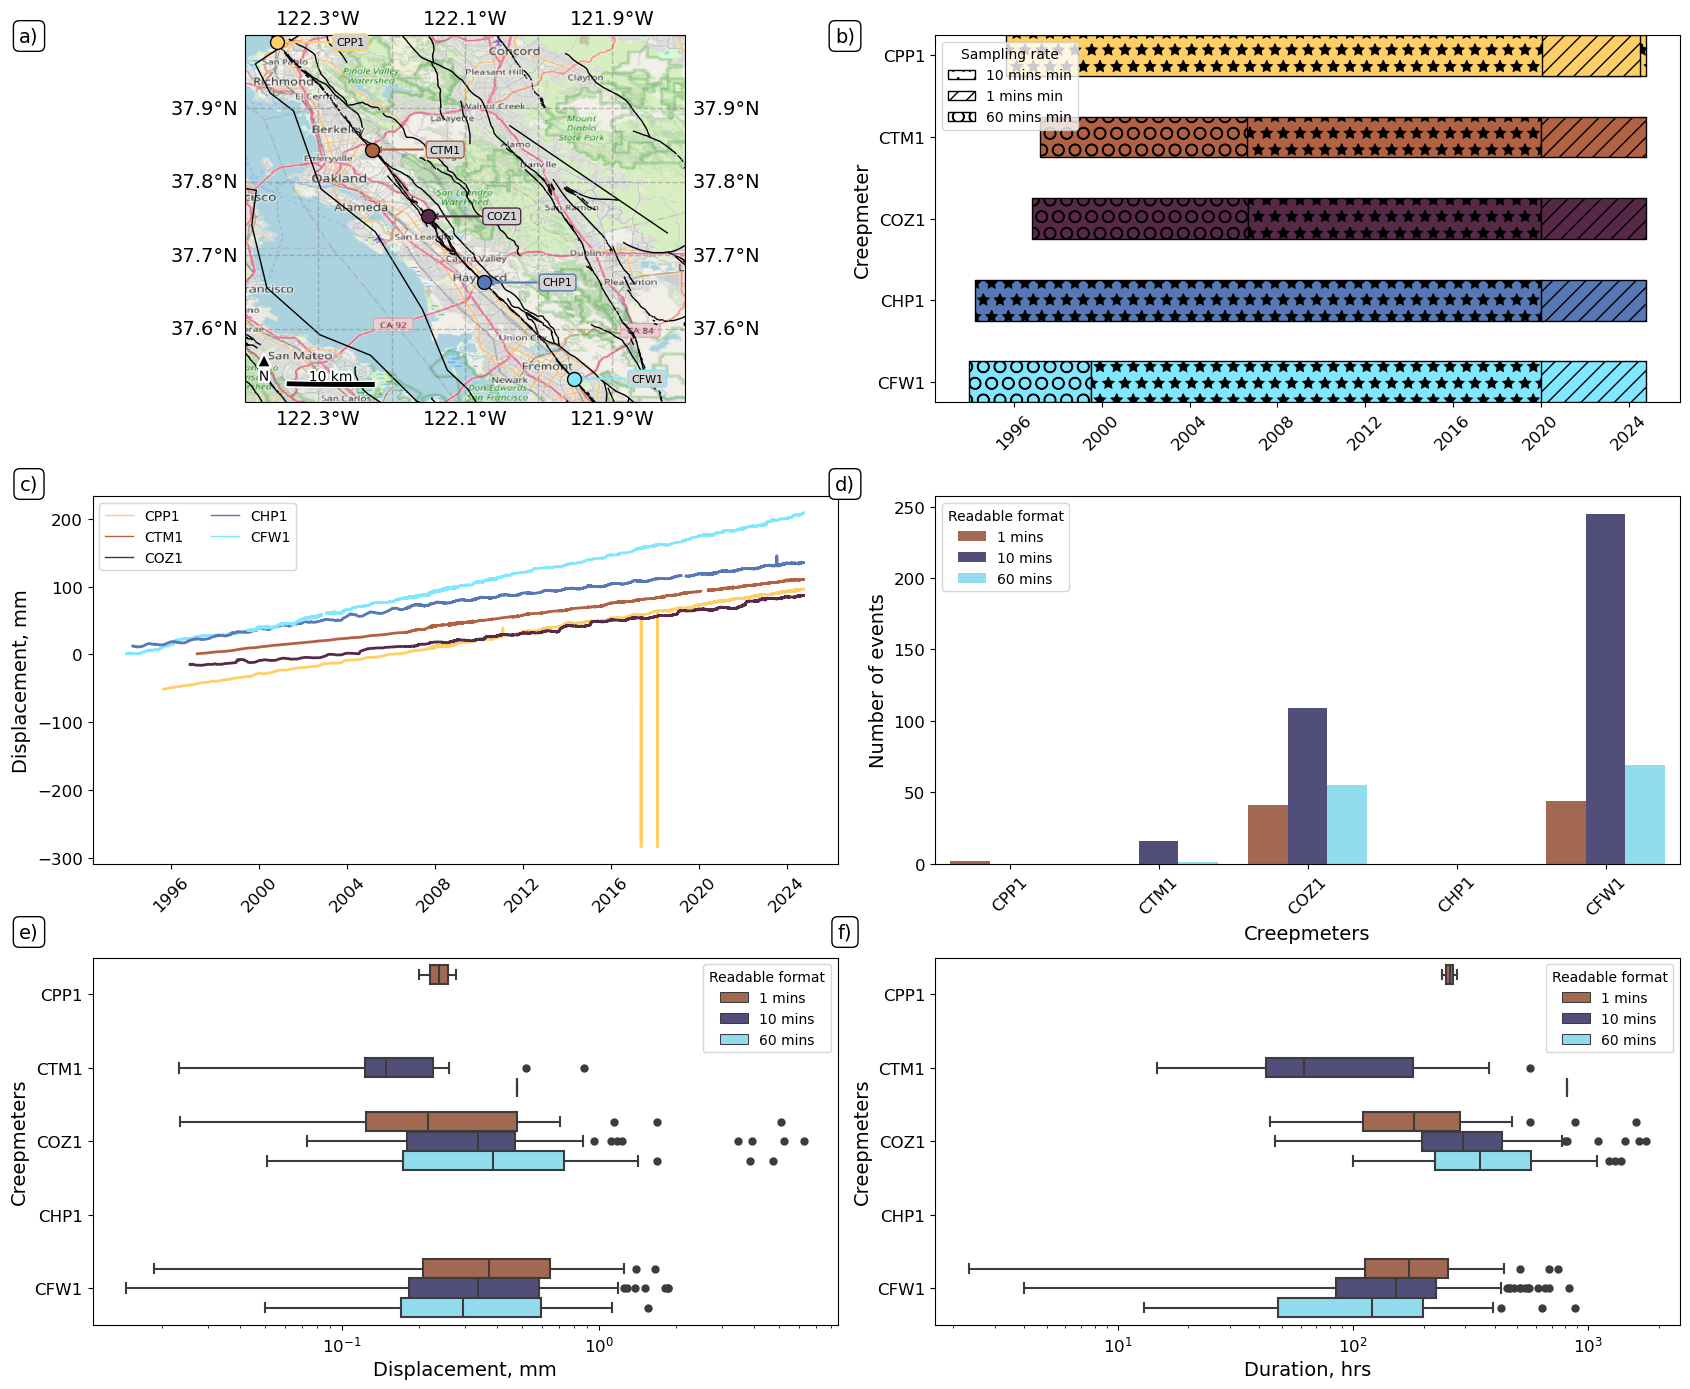

In [7]:
six_panel_plot(df_all,Creepmeter_dataframe,'HAY','Hayward',HAY,cmc.managua,gdf_Cali,'horizontal',HAY_list)

/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1698570974.py:417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region.sort_values(by="Latitude",inplace=True,ascending=False)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1698570974.py:418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region['Creepmeter_abbrv'] = events_region['Creepmeter_abbrv'].astype(str)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1698570974.py:419: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

../../Data/DATA_tidied/SAC/XMM1_10T.SAC
../../Data/DATA_tidied/SAC/XGH1_10T.SAC
../../Data/DATA_tidied/SAC/XSC1_10T.SAC
../../Data/DATA_tidied/SAC/XPK1_10T.SAC
../../Data/DATA_tidied/SAC/WKR1_10T.SAC
../../Data/DATA_tidied/SAC/XTA1_10T.SAC
../../Data/DATA_tidied/SAC/XMD1_10T.SAC
../../Data/DATA_tidied/SAC/X461_10T.SAC
../../Data/DATA_tidied/SAC/XVA1_10T.SAC
../../Data/DATA_tidied/SAC/XRSW_10T.SAC
../../Data/DATA_tidied/SAC/XHSW_10T.SAC
../../Data/DATA_tidied/SAC/CRR1_10T.SAC
../../Data/DATA_tidied/SAC/C461_10T.SAC
../../Data/DATA_tidied/SAC/XPK2_10T.SAC
../../Data/DATA_tidied/SAC/C462_1T.SAC


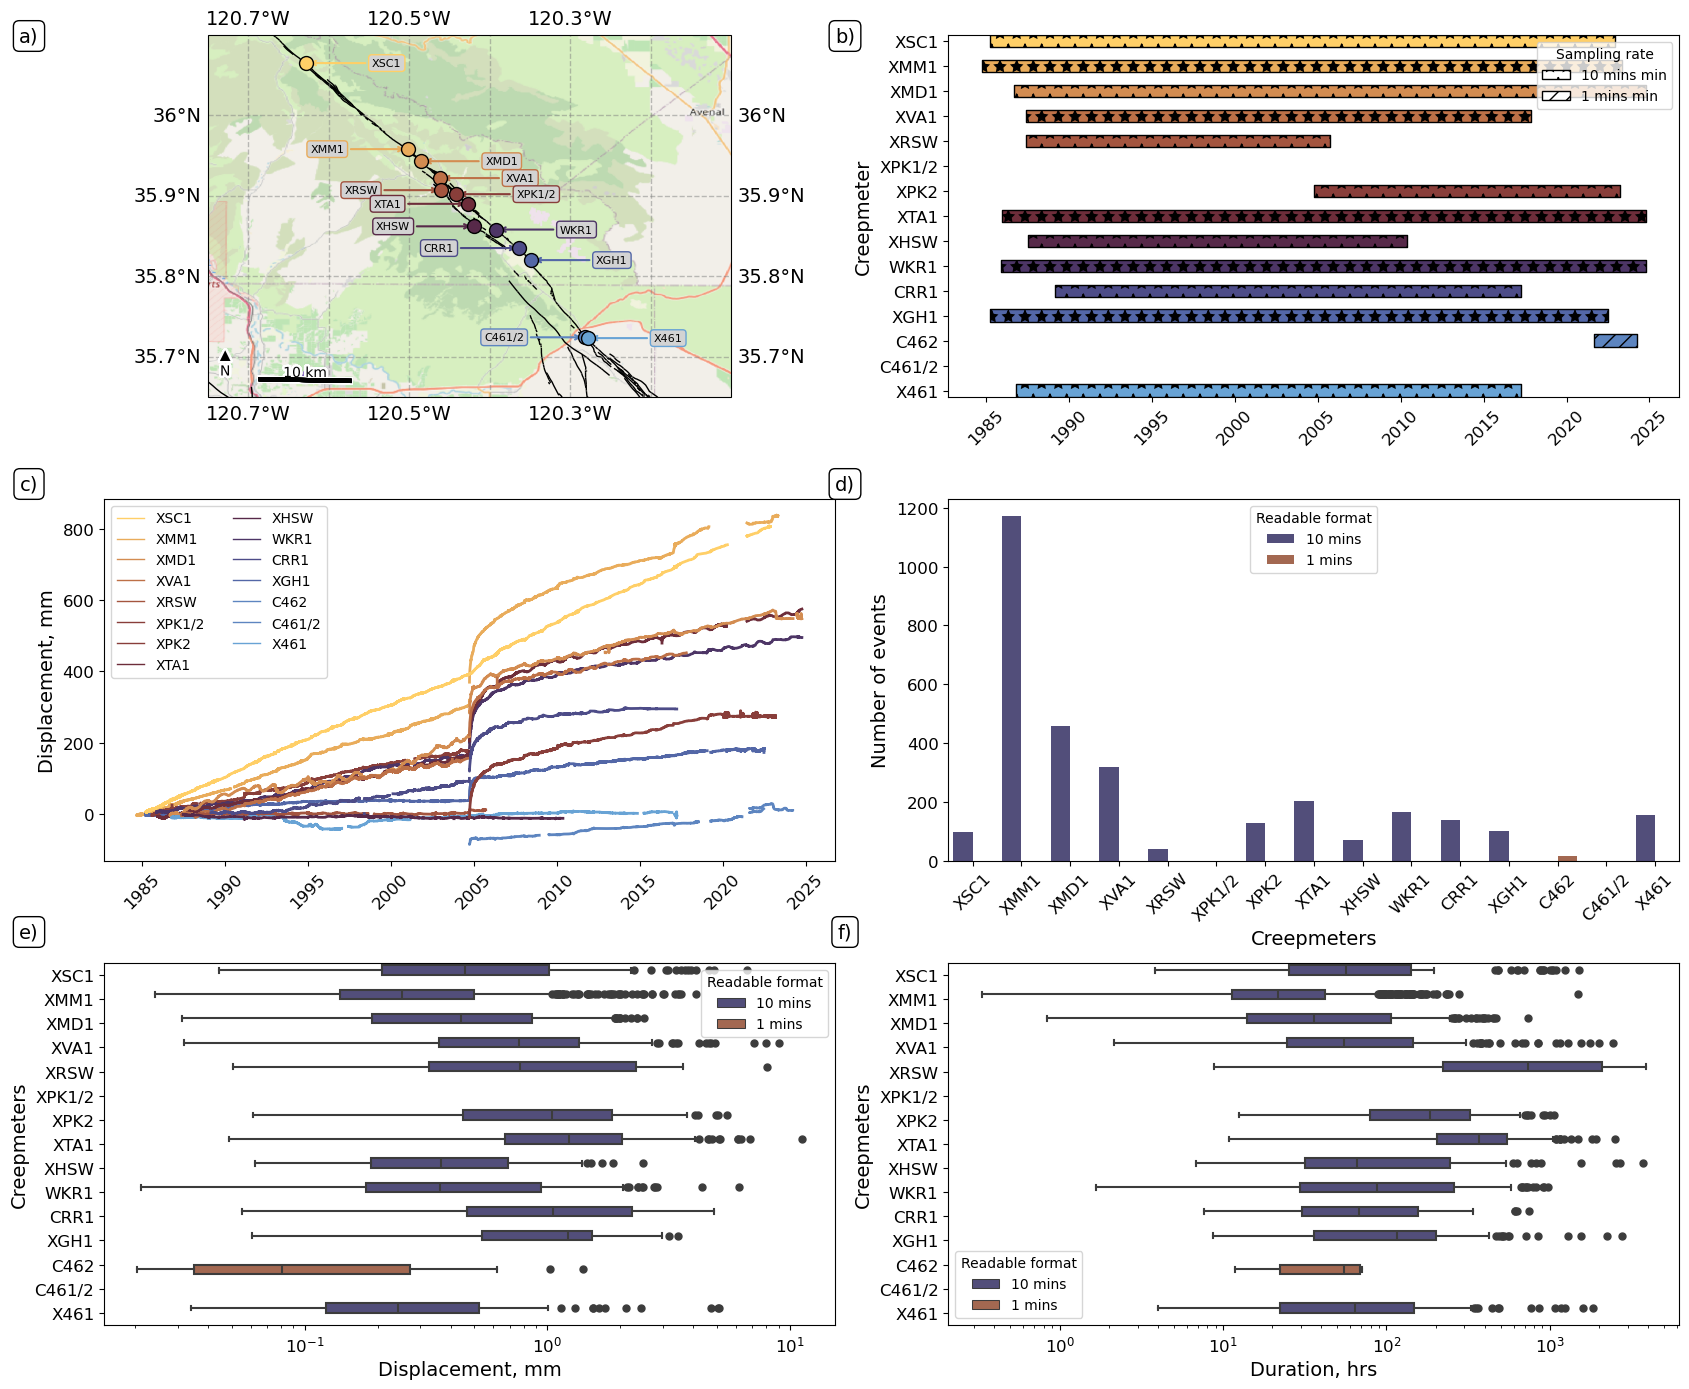

In [8]:
six_panel_plot(df_all,Creepmeter_dataframe,'PARK','Parkfield',PARK,cmc.managua,gdf_Cali,'horizontal',PARK_list)

/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1698570974.py:417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region.sort_values(by="Latitude",inplace=True,ascending=False)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1698570974.py:418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region['Creepmeter_abbrv'] = events_region['Creepmeter_abbrv'].astype(str)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1698570974.py:419: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

../../Data/DATA_tidied/SAC/DU30_1T.SAC
../../Data/DATA_tidied/SAC/DU30_10T.SAC
../../Data/DATA_tidied/SAC/DU30_30T.SAC
../../Data/DATA_tidied/SAC/DU30_5T.SAC
../../Data/DATA_tidied/SAC/FE30_10T.SAC
../../Data/DATA_tidied/SAC/FE30_15T.SAC
../../Data/DATA_tidied/SAC/FE30_30T.SAC
../../Data/DATA_tidied/SAC/FE30_5T.SAC
<urlopen error [Errno 8] nodename nor servname provided, or not known><urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>

<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servname provided, or not known>
<urlopen error [Errno 8] nodename nor servna

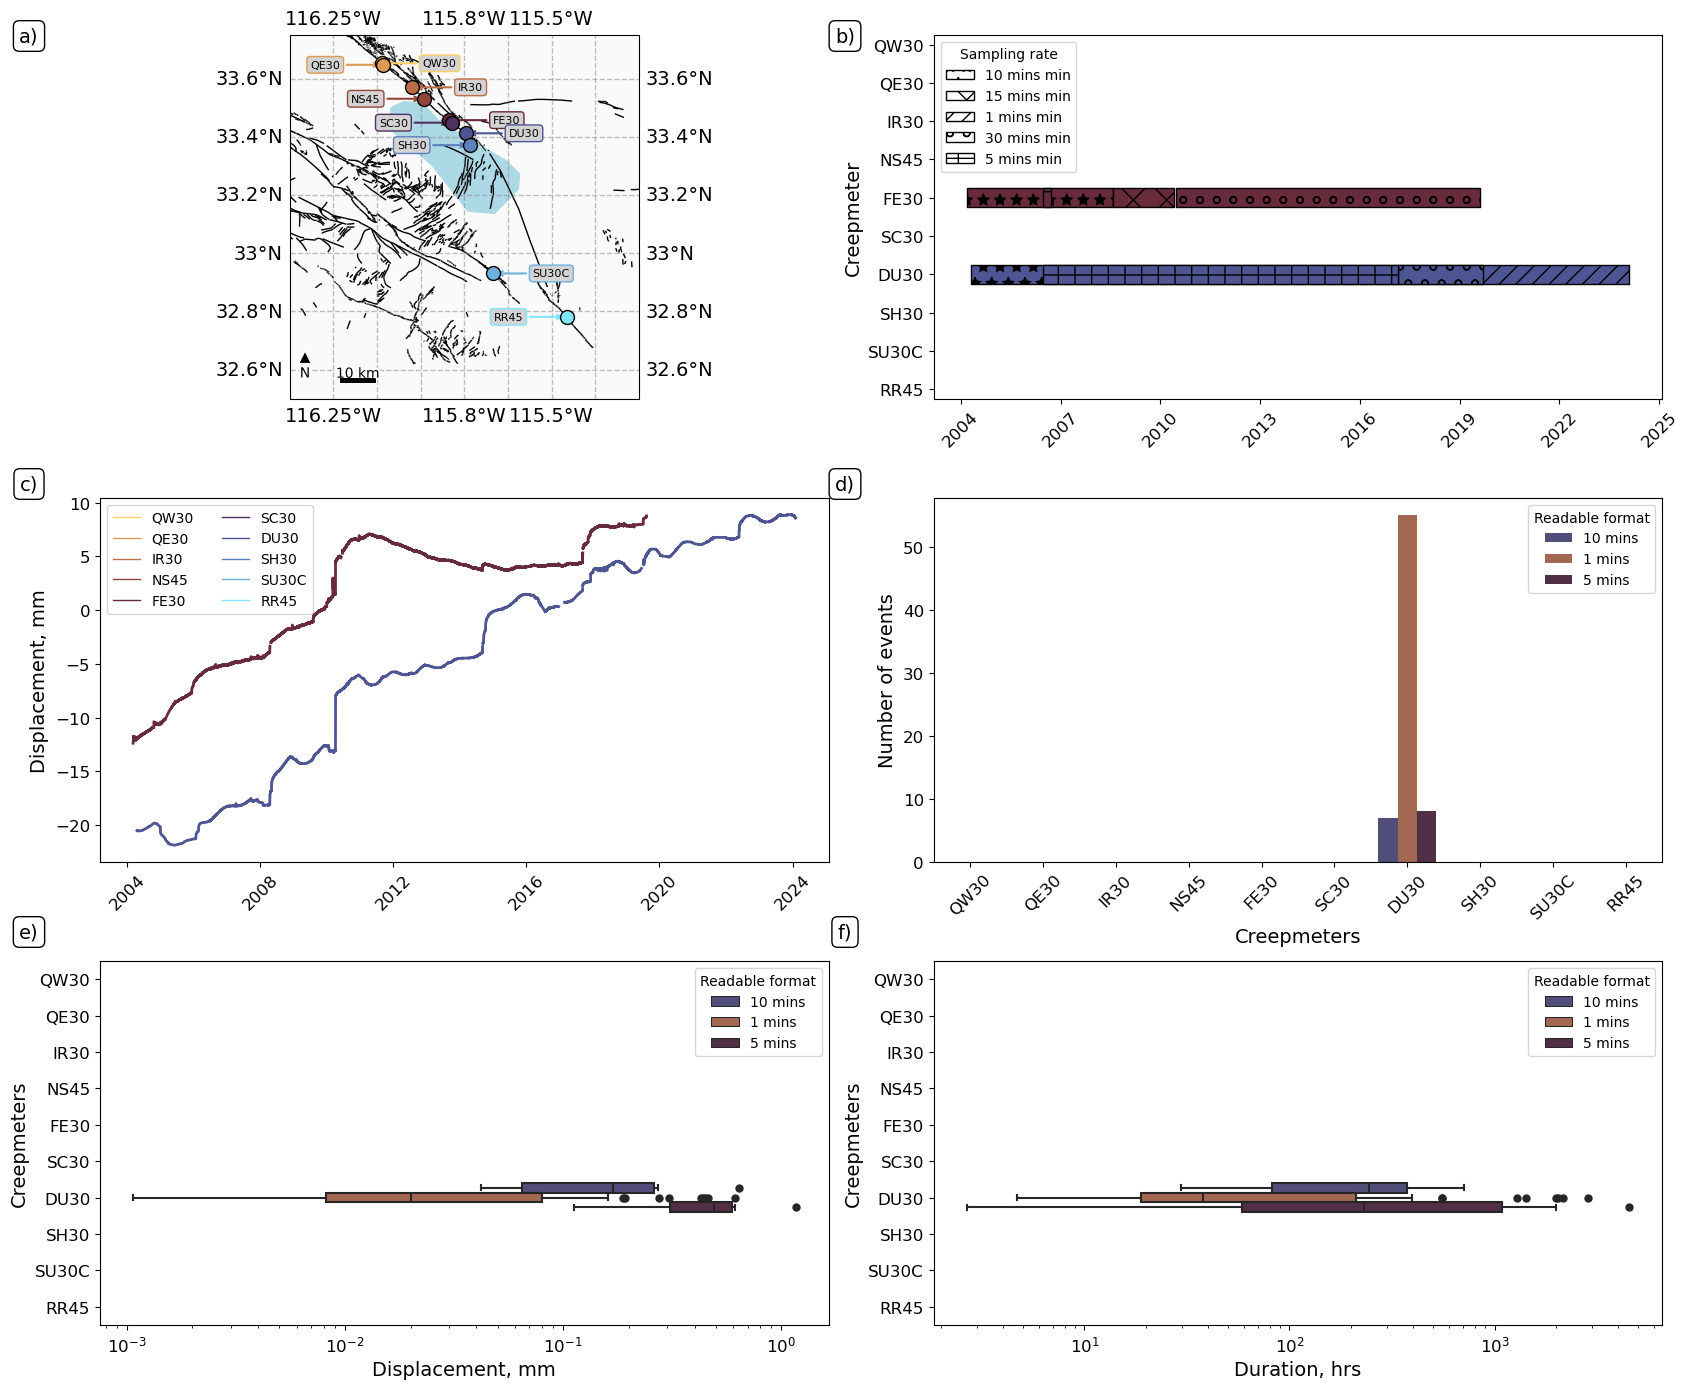

In [9]:
six_panel_plot(df_all,Creepmeter_dataframe,'SOCAL','SoCal',SOCAL,cmc.managua,gdf_Cali,'horizontal',SOCAL_list)

/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1698570974.py:417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region.sort_values(by="Latitude",inplace=True,ascending=False)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1698570974.py:418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region['Creepmeter_abbrv'] = events_region['Creepmeter_abbrv'].astype(str)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1698570974.py:419: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

../../Data/DATA_tidied/SAC/RB_1T.SAC
../../Data/DATA_tidied/SAC/R7_1T.SAC
../../Data/DATA_tidied/SAC/GS_10S.SAC
../../Data/DATA_tidied/SAC/RA_10S.SAC
../../Data/DATA_tidied/SAC/GB_10S.SAC
../../Data/DATA_tidied/SAC/RB_10S.SAC
../../Data/DATA_tidied/SAC/R7_10S.SAC
../../Data/DATA_tidied/SAC/GS_1T.SAC
../../Data/DATA_tidied/SAC/GD_1T.SAC
../../Data/DATA_tidied/SAC/RA_1T.SAC
../../Data/DATA_tidied/SAC/GB_10T.SAC
../../Data/DATA_tidied/SAC/GS_10T.SAC
../../Data/DATA_tidied/SAC/GD_5T.SAC


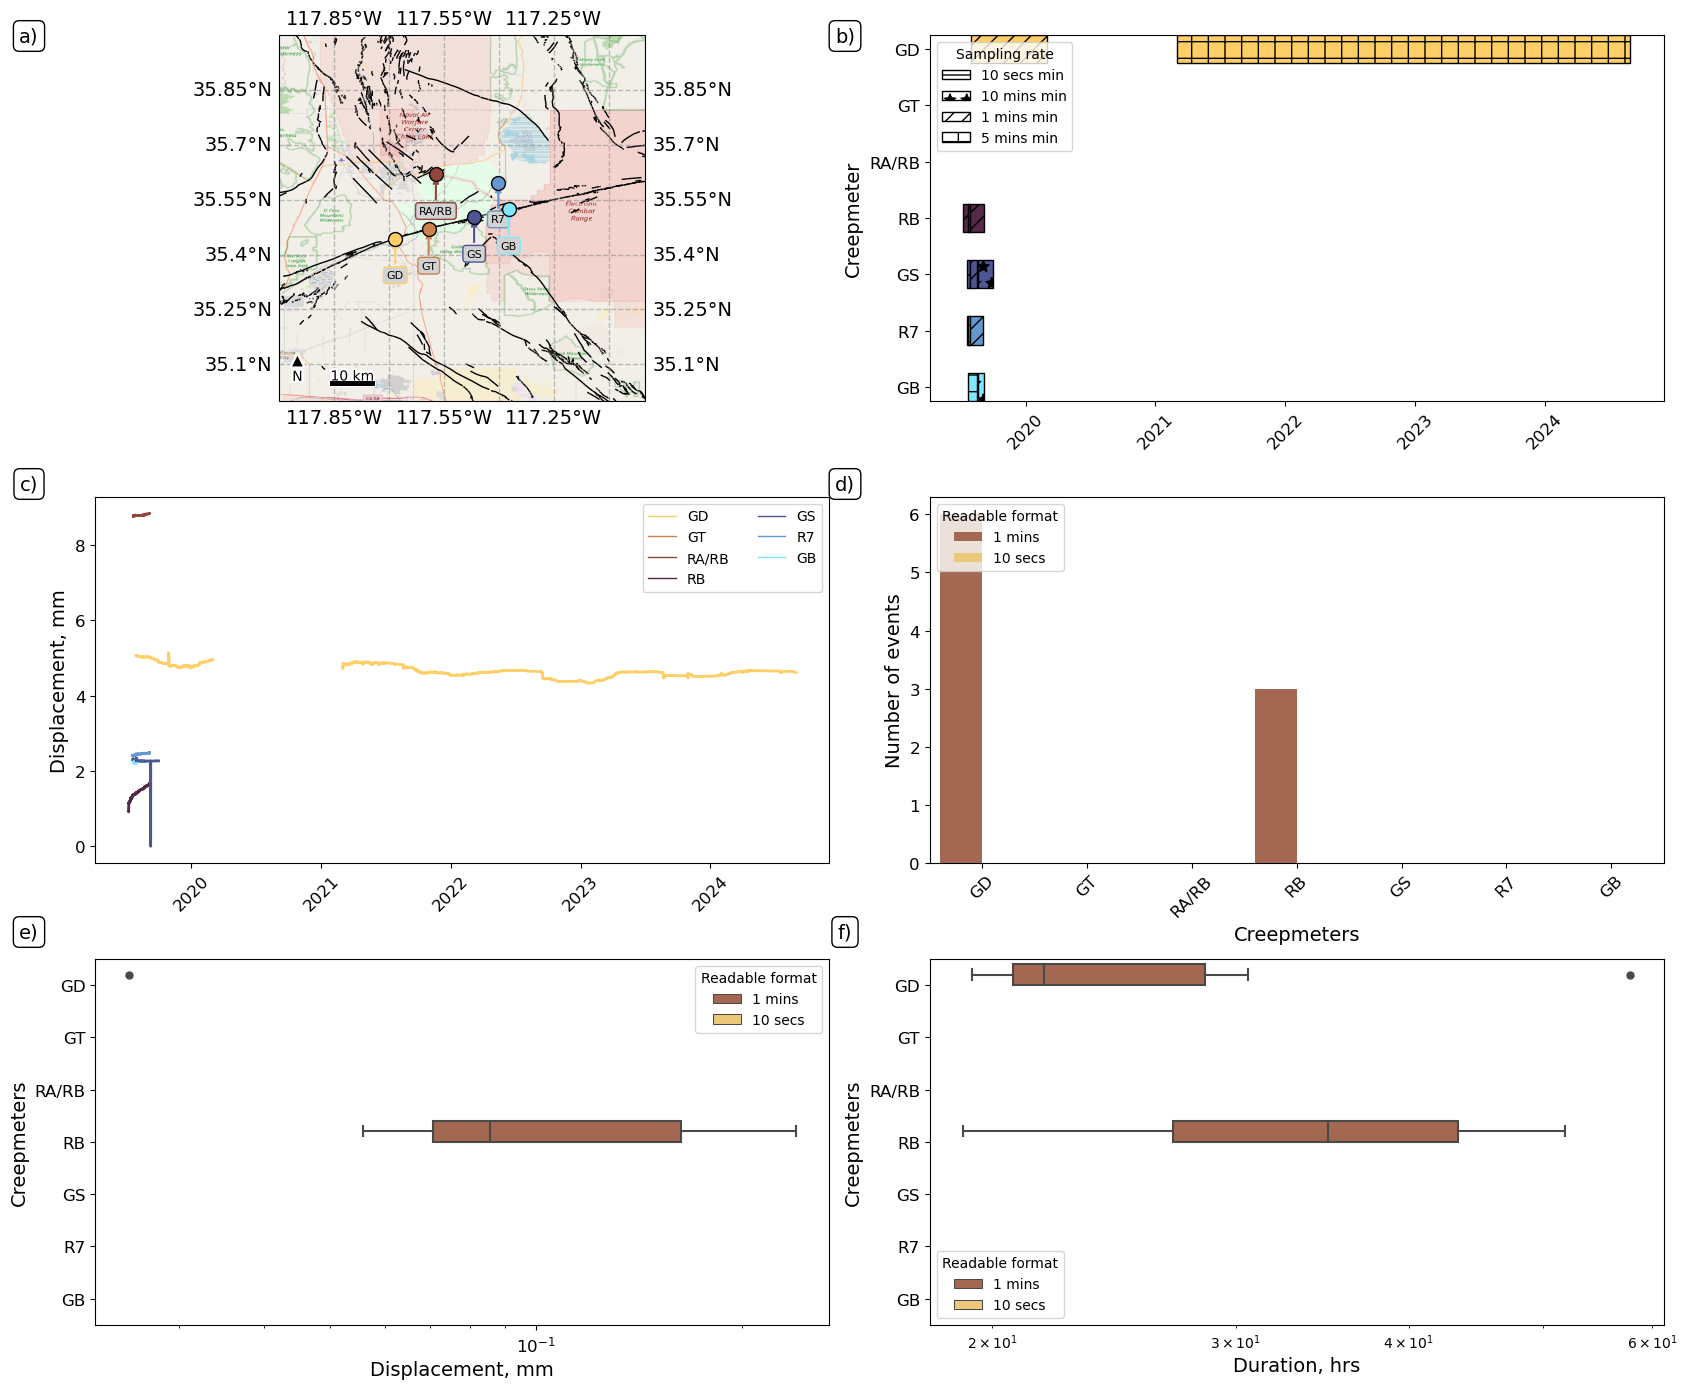

In [10]:
six_panel_plot(df_all,Creepmeter_dataframe,'RID','Ridge',RID,cmc.managua,gdf_Cali,'vertical',RID_list)

/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1698570974.py:417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region.sort_values(by="Latitude",inplace=True,ascending=False)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1698570974.py:418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region['Creepmeter_abbrv'] = events_region['Creepmeter_abbrv'].astype(str)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1698570974.py:419: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

../../Data/DATA_tidied/SAC/CAN1_30T.SAC


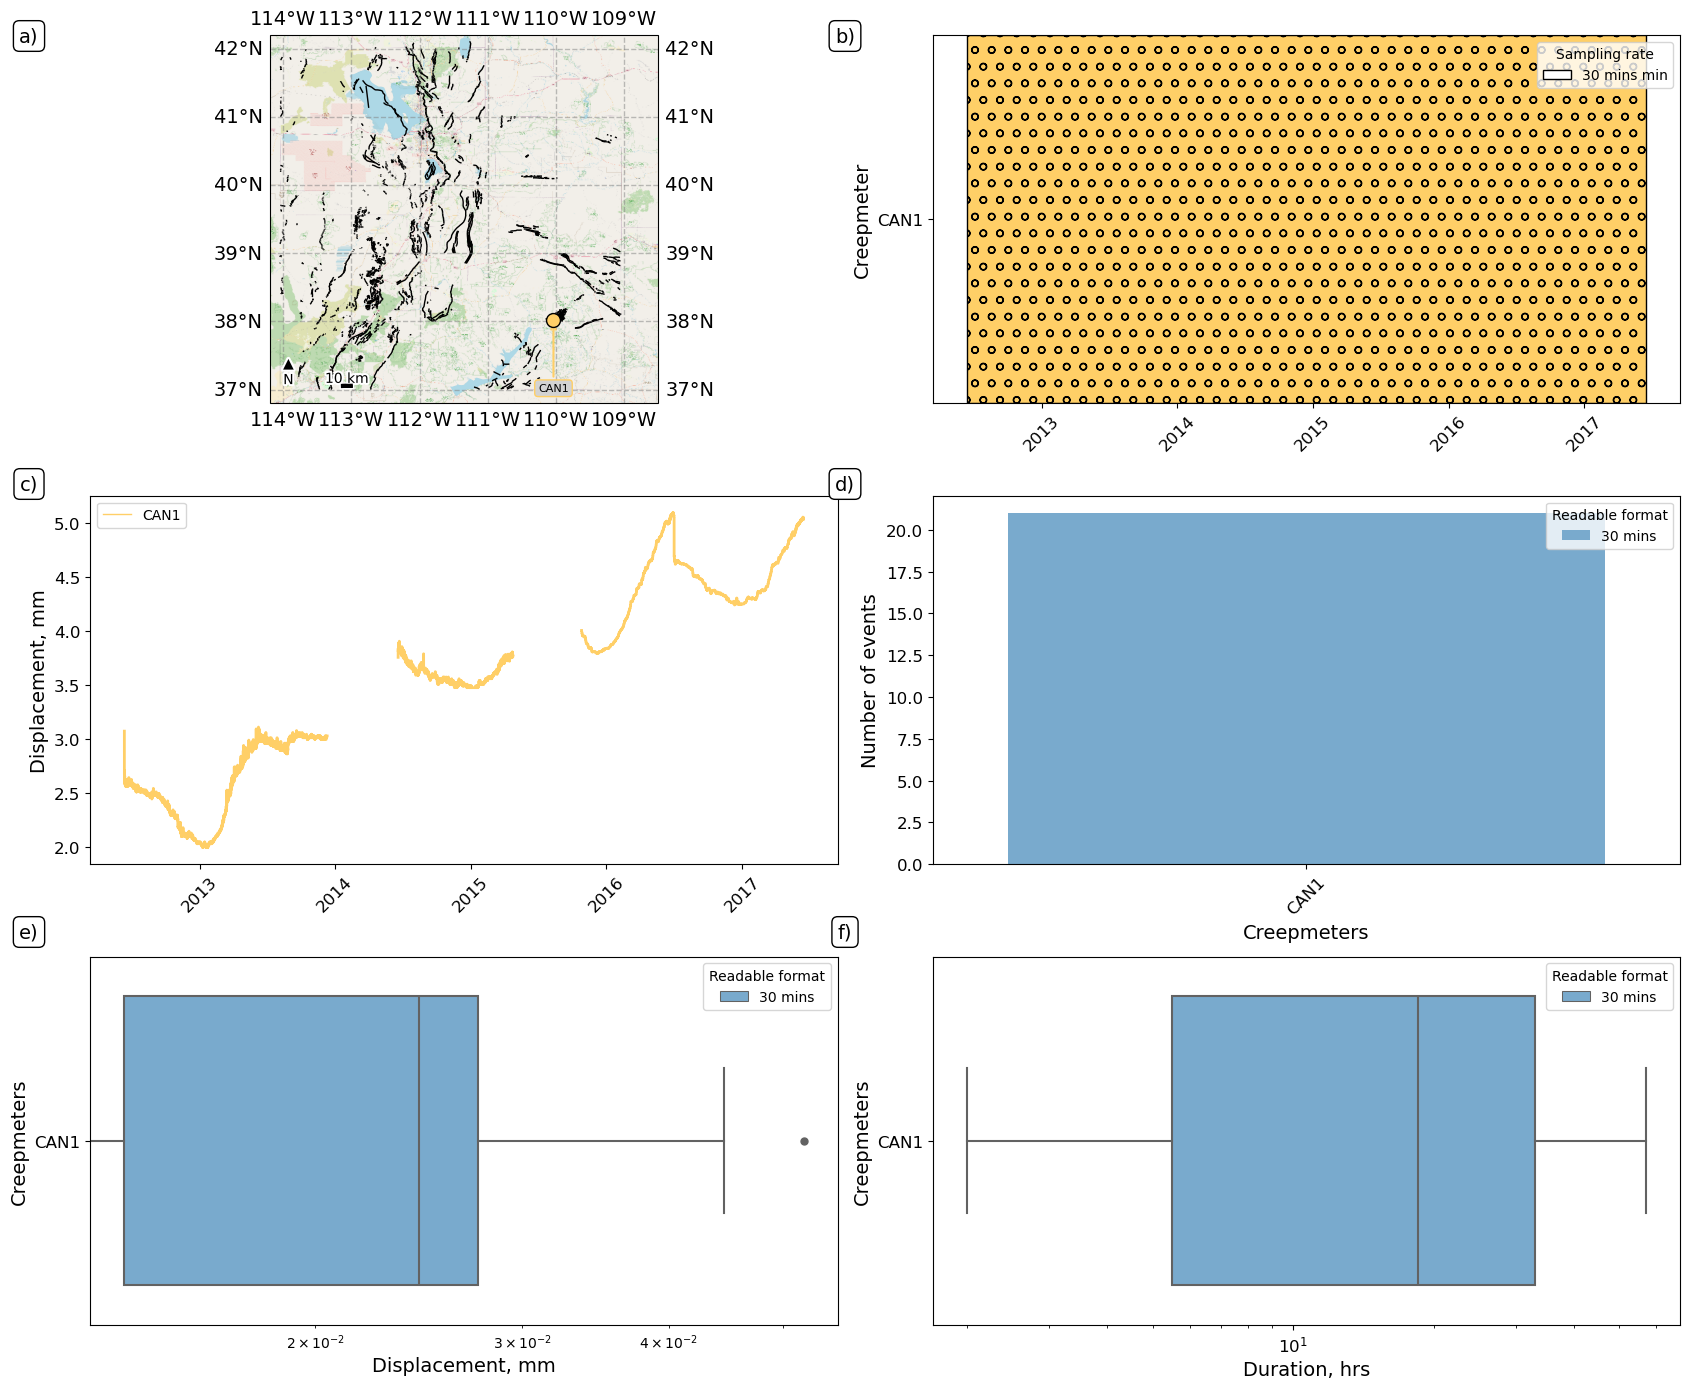

In [11]:
six_panel_plot(df_all,Creepmeter_dataframe,'UTA','Utah',UTA,cmc.managua,gdf_Utah,'vertical',UTA_list)

/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1698570974.py:417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region.sort_values(by="Latitude",inplace=True,ascending=False)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1698570974.py:418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region['Creepmeter_abbrv'] = events_region['Creepmeter_abbrv'].astype(str)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1698570974.py:419: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

../../Data/DATA_tidied/SAC/PAN1_1T.SAC
../../Data/DATA_tidied/SAC/PAS1_1T.SAC
../../Data/DATA_tidied/SAC/PAN1_5T.SAC
../../Data/DATA_tidied/SAC/PAS1_5T.SAC
../../Data/DATA_tidied/SAC/SIV1_10S.SAC
../../Data/DATA_tidied/SAC/SIV1_1T.SAC
../../Data/DATA_tidied/SAC/HAT1_1T.SAC
../../Data/DATA_tidied/SAC/KIR1_1T.SAC
../../Data/DATA_tidied/SAC/HAS1_1T.SAC
../../Data/DATA_tidied/SAC/BAL1_1T.SAC
../../Data/DATA_tidied/SAC/GOZ1_1T.SAC
../../Data/DATA_tidied/SAC/ORM1_1T.SAC
../../Data/DATA_tidied/SAC/YZW1_1T.SAC
../../Data/DATA_tidied/SAC/GOK1_1T.SAC
../../Data/DATA_tidied/SAC/TAS1_1T.SAC
../../Data/DATA_tidied/SAC/KAR1_1T.SAC
../../Data/DATA_tidied/SAC/YZE1_1T.SAC
../../Data/DATA_tidied/SAC/TAS1_10T.SAC


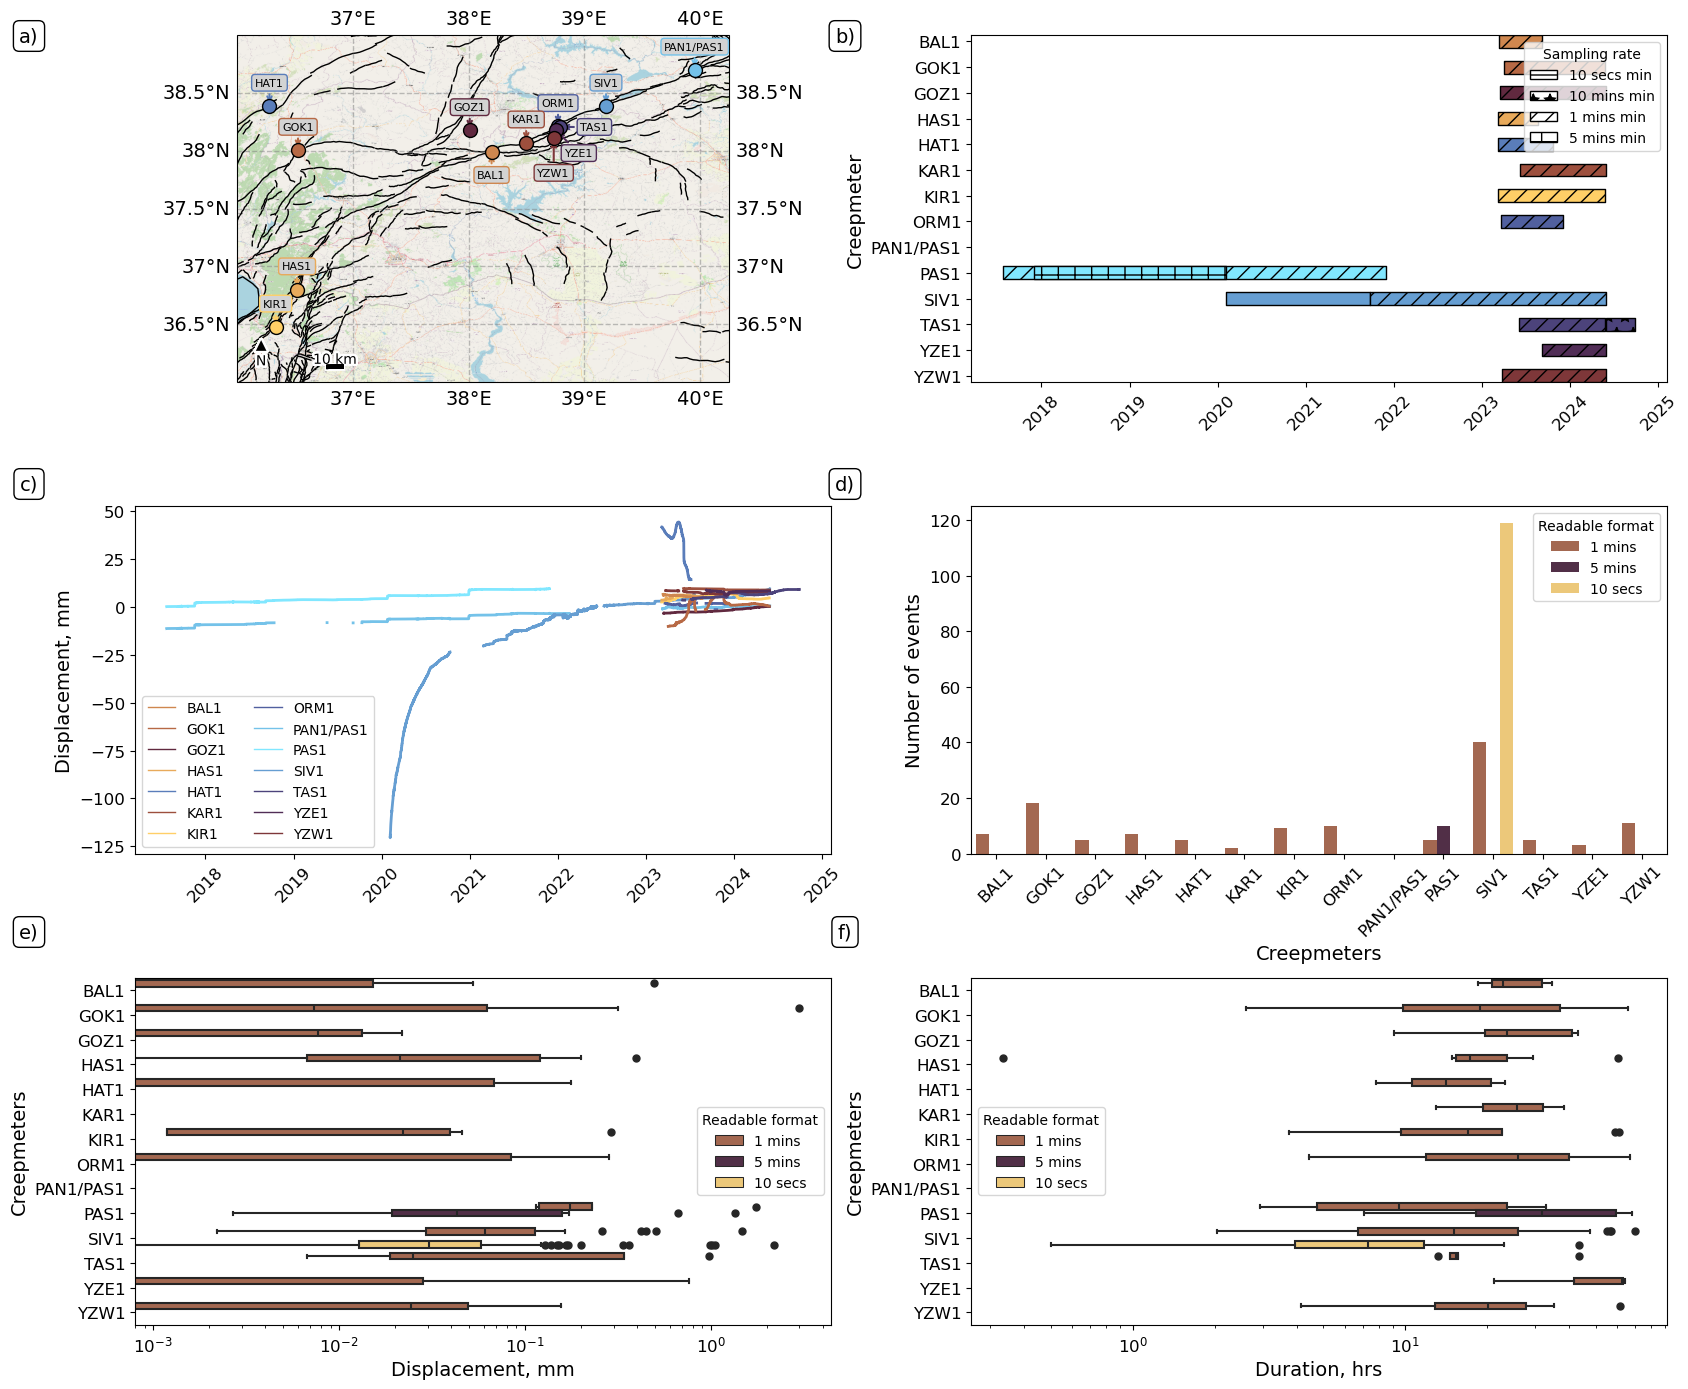

In [12]:
six_panel_plot(df_all,Creepmeter_dataframe,'EAF','EAF',EAF,cmc.managua,gdf_Asia,'vertical',EAF_list)

/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1698570974.py:417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region.sort_values(by="Latitude",inplace=True,ascending=False)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1698570974.py:418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region['Creepmeter_abbrv'] = events_region['Creepmeter_abbrv'].astype(str)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1698570974.py:419: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

../../Data/DATA_tidied/SAC/INW1_30T.SAC
../../Data/DATA_tidied/SAC/PET1_30T.SAC
../../Data/DATA_tidied/SAC/ESZ1_5T.SAC
../../Data/DATA_tidied/SAC/WSZ1_5T.SAC
../../Data/DATA_tidied/SAC/CHE1_5T.SAC
../../Data/DATA_tidied/SAC/ESZ1_1T.SAC
../../Data/DATA_tidied/SAC/WSZ1_1T.SAC
../../Data/DATA_tidied/SAC/PET1_1T.SAC
../../Data/DATA_tidied/SAC/ISW1_1T.SAC
../../Data/DATA_tidied/SAC/CER1_1T.SAC
../../Data/DATA_tidied/SAC/CHE1_1T.SAC
../../Data/DATA_tidied/SAC/HAM1_1T.SAC
../../Data/DATA_tidied/SAC/SEL1_30S.SAC
../../Data/DATA_tidied/SAC/TEP1_30S.SAC
../../Data/DATA_tidied/SAC/INW1_1T.SAC
../../Data/DATA_tidied/SAC/CER1_30S.SAC
../../Data/DATA_tidied/SAC/CHE1_30S.SAC


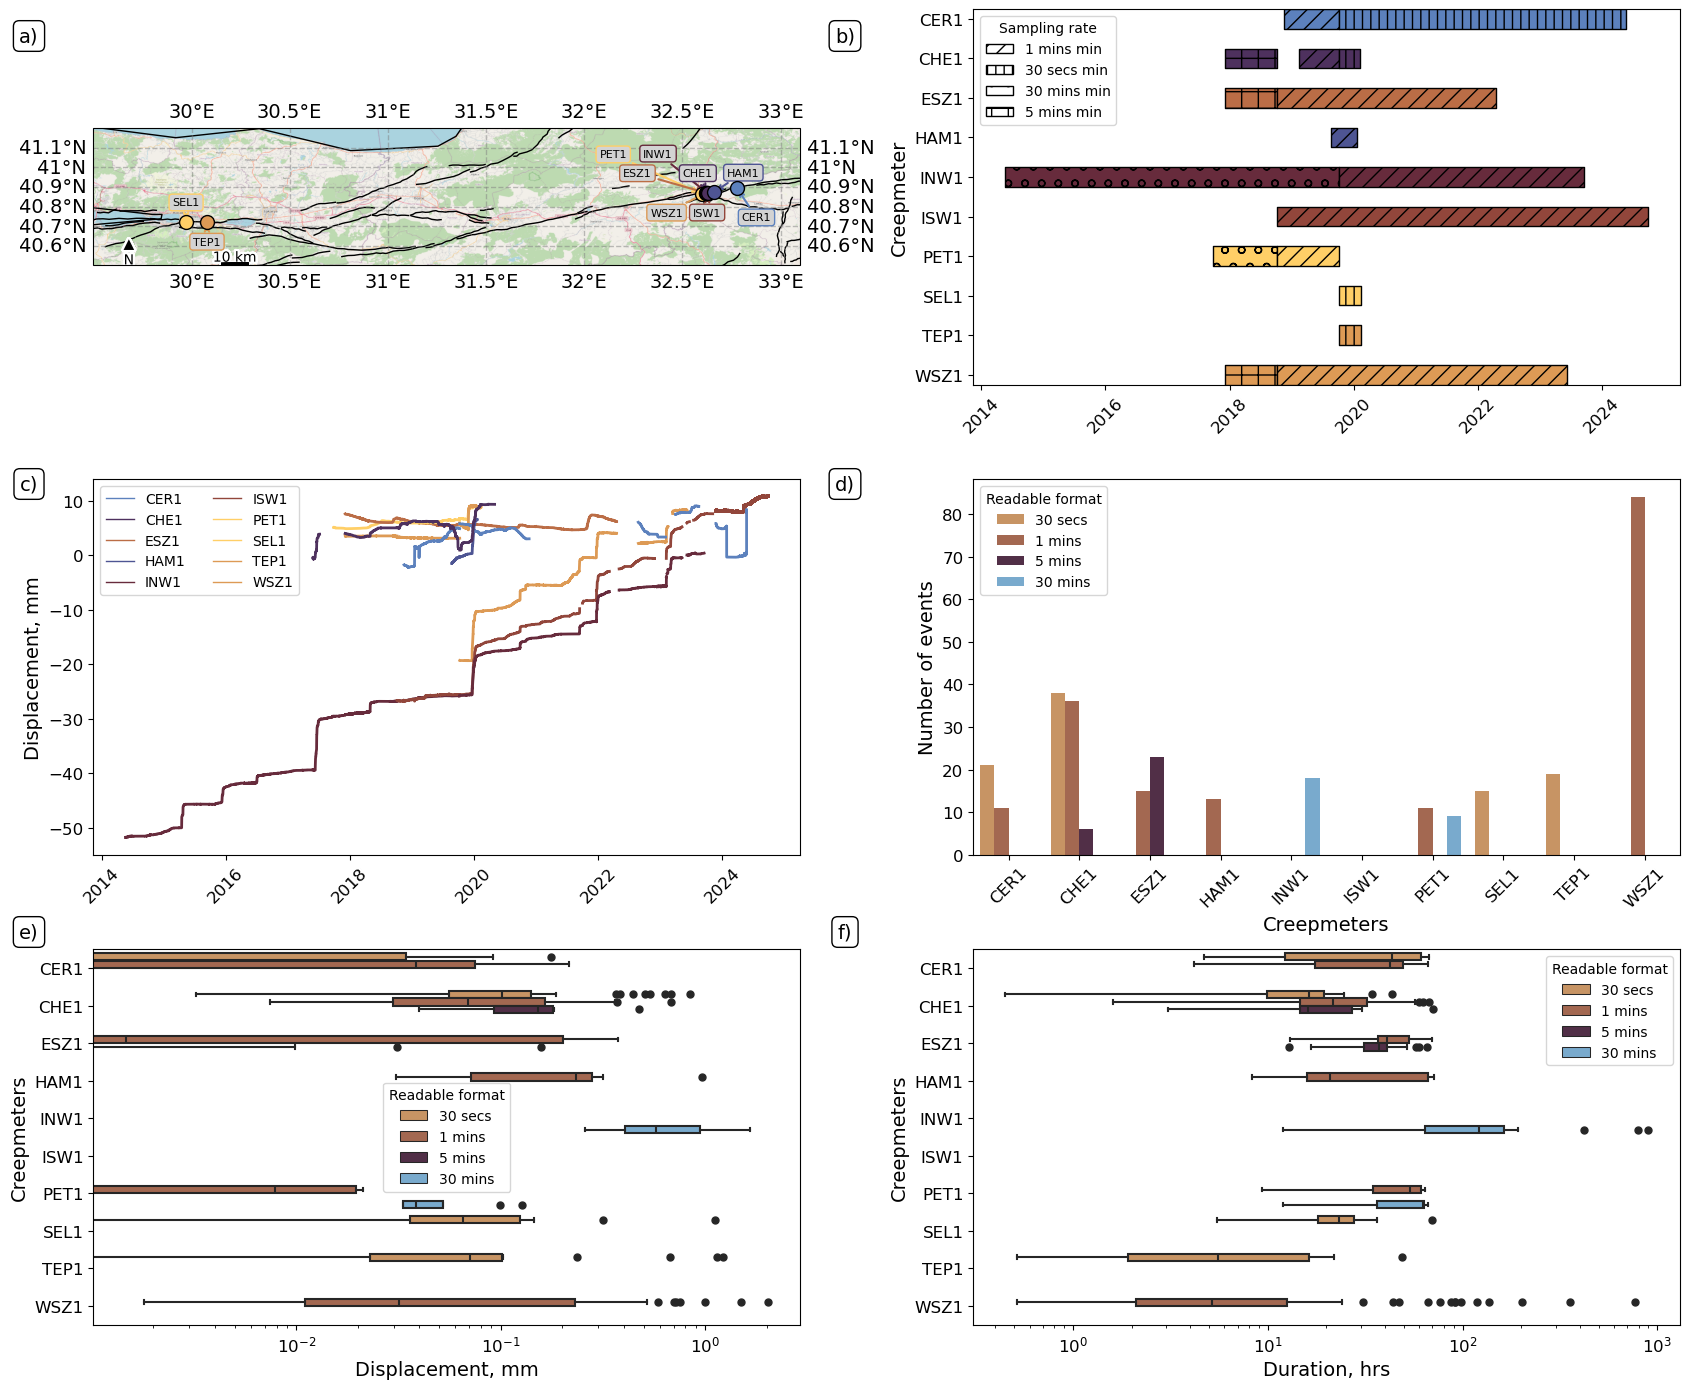

In [13]:
six_panel_plot(df_all,Creepmeter_dataframe,'NAF','NAF',NAF,cmc.managua,gdf_Asia,'vertical',NAF_list)

/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1698570974.py:417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region.sort_values(by="Latitude",inplace=True,ascending=False)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1698570974.py:418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_region['Creepmeter_abbrv'] = events_region['Creepmeter_abbrv'].astype(str)
/var/folders/56/47k8q3q1449cq8kwzkz5r8ch0000gr/T/ipykernel_32042/1698570974.py:419: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

../../Data/DATA_tidied/SAC/CHA1_10T.SAC


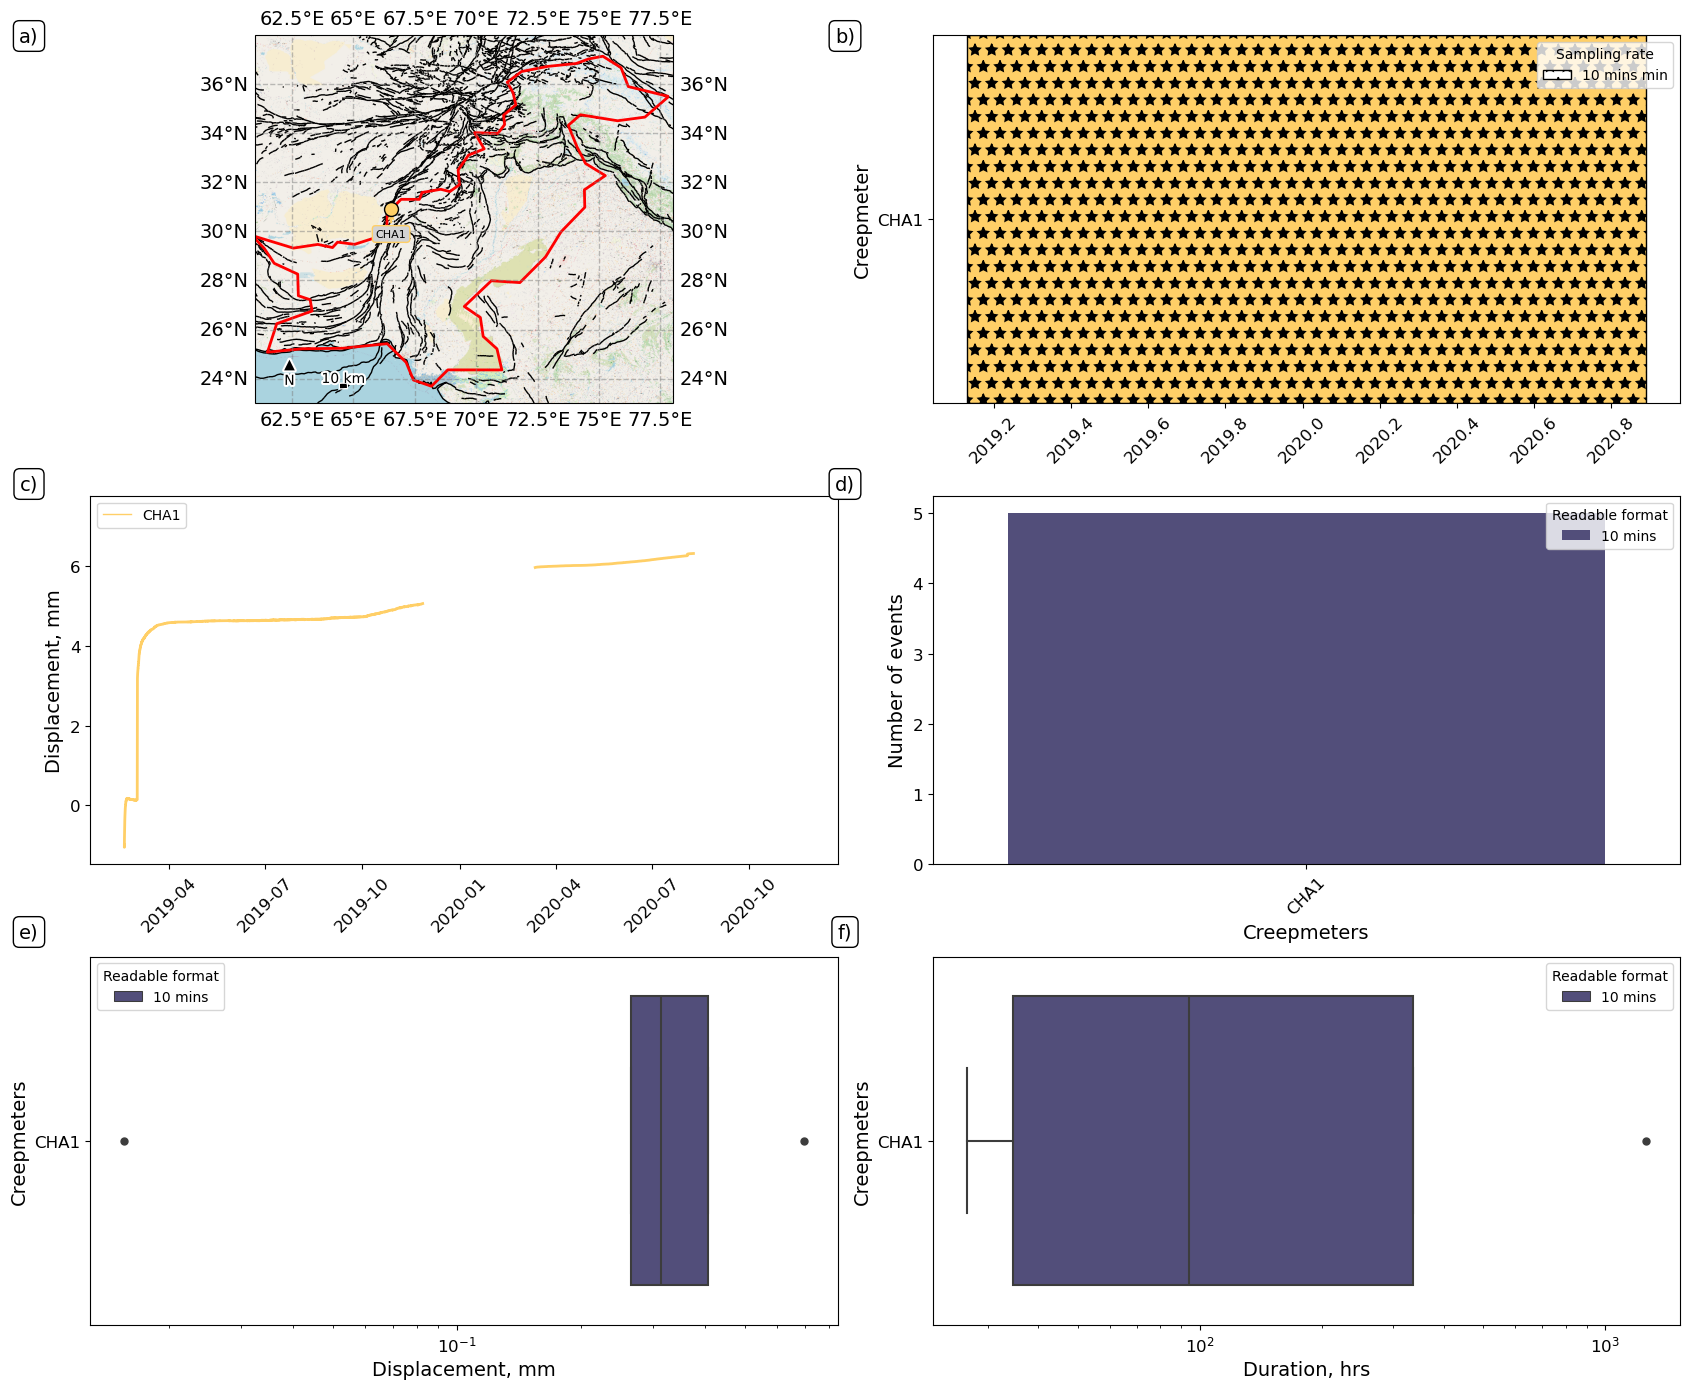

In [14]:
six_panel_plot(df_all,Creepmeter_dataframe,'CHAF','Chaman',CHAF,cmc.managua,gdf_Asia,'vertical',CHAF_list)